In [1]:
import pandas as pd
from time import time
import numpy as np
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from scipy.stats import linregress
from matplotlib import pyplot
import seaborn as sns
sns.set_style('ticks')

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Conv1D, Input, Reshape, Dropout, LeakyReLU, MaxPooling1D
from keras.optimizers import Adam, RMSprop, Nadam
from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [2]:
raw_df = pd.read_csv('data/history/ADABTC.csv')
raw_df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number Trades,Taker Base Asset Volume,Take Quote Asset Volume,Ignore
0,1516402800000,0.000056,0.000056,0.000056,0.000056,97448.0,1516403099999,5.475902,123,48352.0,2.718388,0
1,1516403100000,0.000056,0.000056,0.000056,0.000056,65878.0,1516403399999,3.699381,108,40093.0,2.251596,0
2,1516403400000,0.000056,0.000056,0.000056,0.000056,54614.0,1516403699999,3.064731,102,24254.0,1.361470,0
3,1516403700000,0.000056,0.000056,0.000056,0.000056,62223.0,1516403999999,3.492357,114,44992.0,2.525945,0
4,1516404000000,0.000056,0.000056,0.000056,0.000056,64601.0,1516404299999,3.628620,92,33380.0,1.875234,0


In [3]:
ndf = raw_df.filter(items=['Open', 'High', 'Low', 'Close', 'Volume', 'Number Trades', 'Quote Asset Volume', 'Taker Base Asset Volume', 'Taker Quote Asset Volume'])
ndf = ndf.set_index(pd.to_datetime(raw_df['Open Time'],unit='ms'))
ndf.dropna(inplace=True)

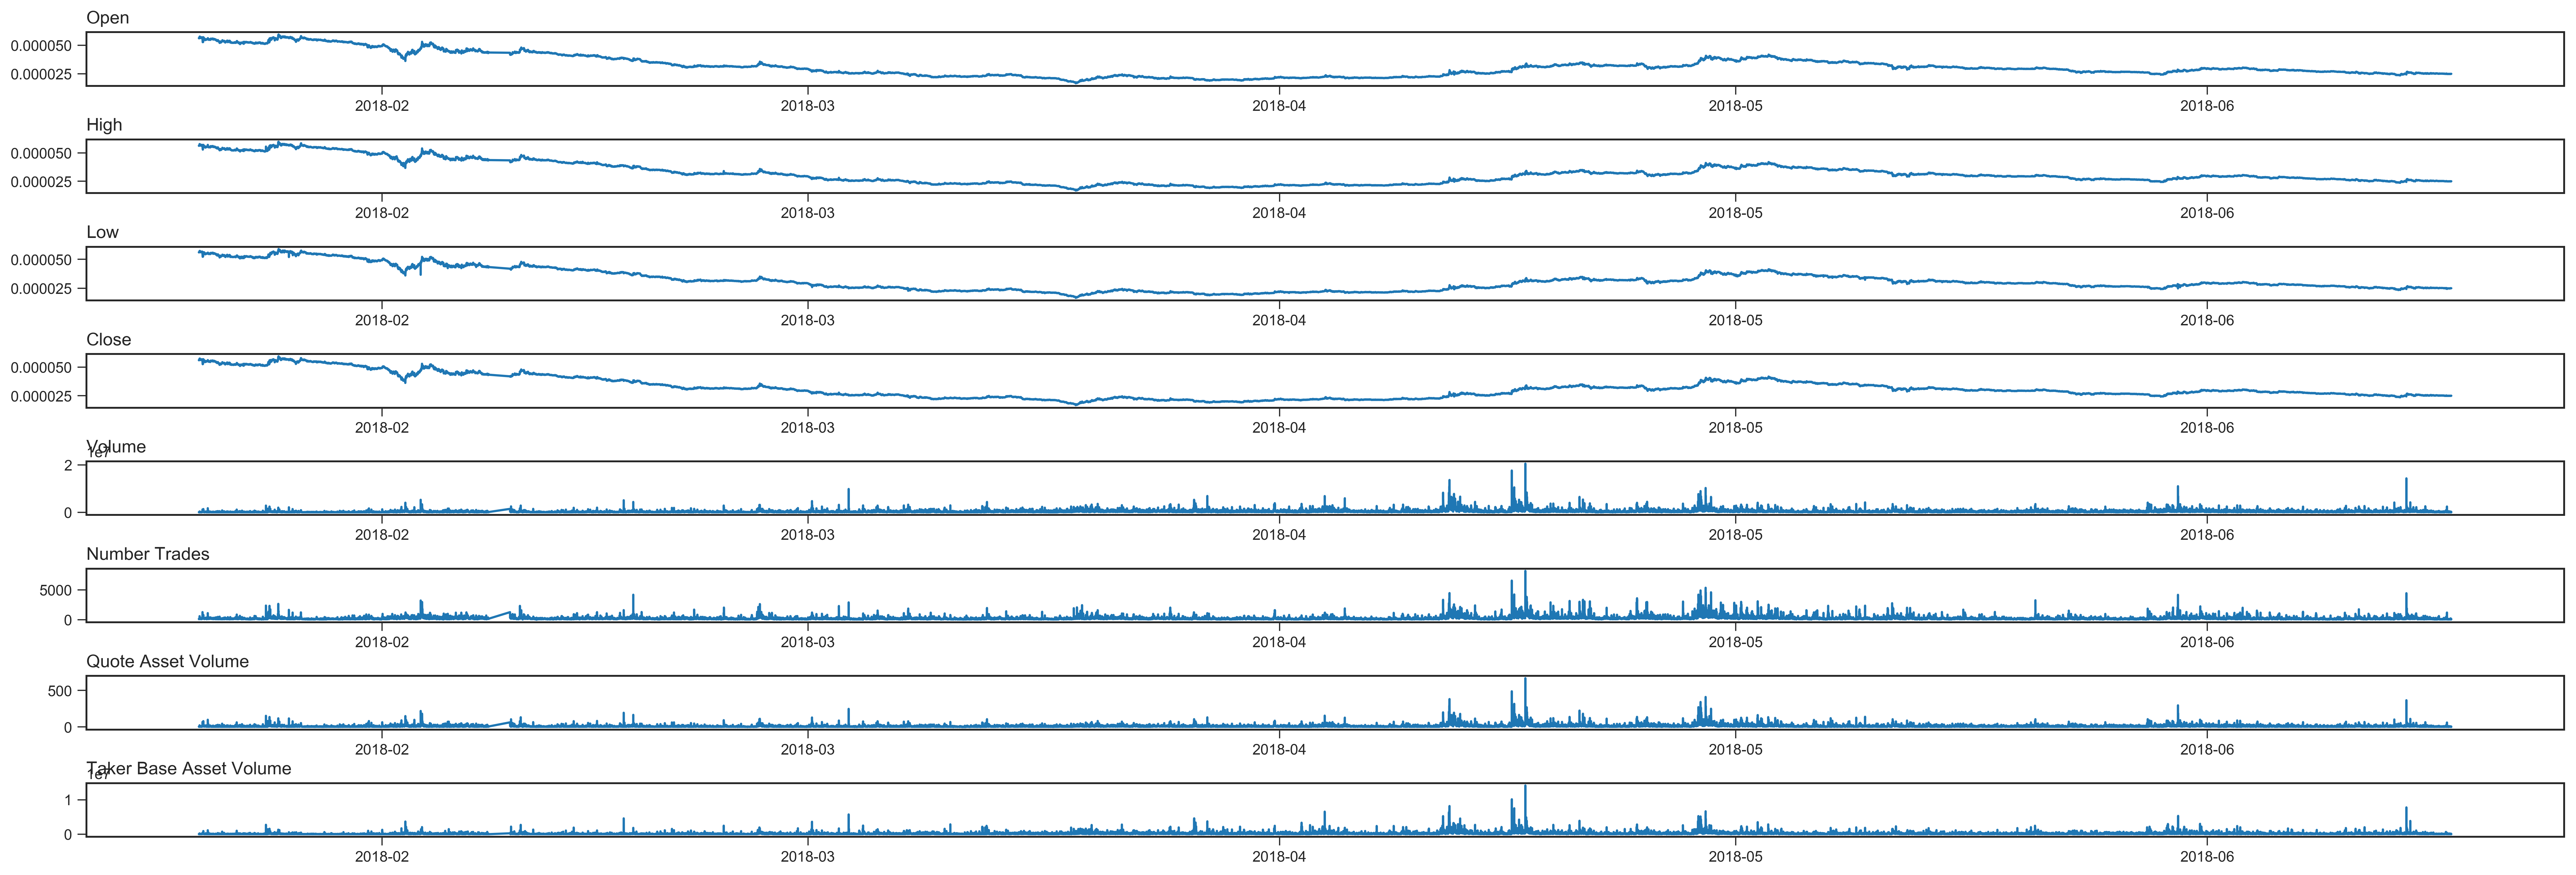

In [4]:
# specify columns to plot
cols = ndf.columns
i = 1
# plot each column
pyplot.figure(figsize=(30, 10), dpi=400)
pyplot.subplots_adjust(hspace = 1)
for col in cols:
    pyplot.subplot(len(cols), 1, i)
    pyplot.plot(ndf[col])
    pyplot.title(col, y=1, loc='left')
    i += 1
pyplot.show()

In [5]:
andf = ndf.apply(lambda c: minmax_scale(X=c, feature_range=(0, 1)))

C:\Users\Trey\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [6]:
def frame_to_features(df, time_in, time_out):
    f = []
    n_features = len(df.columns)
    for i in range(time_in, len(andf)):
        # reshape input to be 3D [samples, timesteps, features]
        f.append([
            df.iloc[i - time_in:i].values,
#             df['Open'].iloc[i - time_out + 2:i + 2].values
            df['Open'].iloc[i:i+time_out].values
        ])
    return f

In [7]:
history_length = 500
prediction_length = 2
fs = frame_to_features(andf, history_length, prediction_length)

In [8]:
# split into train and test sets
train = [x[0] for x in fs][:-(prediction_length-1)]
test = [x[1] for x in fs][:-(prediction_length-1)]
# split into input and outputs
train_X, test_X = np.array(train[:int(len(train)*0.7)]), np.array(train[int(len(train)*0.7):])
train_y = np.array(test[:int(len(test)*0.7)])
test_y  = np.array(test[int(len(test)*0.7):])

In [9]:
try:
    print(brain.sumarry())
except:
    kernel_length = int(history_length/10)

    history_cnn_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
    # history_cnn_out = Reshape((1, self.state_size))(history_cnn_input)
    history_cnn_out = Conv1D(filters=64, kernel_size=kernel_length, padding='same', activation='linear')(history_cnn_input)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    history_cnn_out = MaxPooling1D()(history_cnn_out)
    history_cnn_out = Conv1D(filters=48, kernel_size=kernel_length, padding='same', activation='linear')(history_cnn_out)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    history_cnn_out = MaxPooling1D()(history_cnn_out)
    history_cnn_out = Conv1D(filters=32, kernel_size=kernel_length, padding='same', activation='linear')(history_cnn_out)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    history_cnn_out = MaxPooling1D()(history_cnn_out)
    history_cnn_out = Flatten()(history_cnn_out)
    history_cnn_out = Dense(max(int(history_length * 0.5), 10), activation='linear')(history_cnn_out)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    # history_cnn_out = Dropout(0.1)(history_cnn_out)
    history_cnn_out = Dense(max(int(history_length * 0.2), 10), activation='linear')(history_cnn_out)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    # history_cnn_out = Dense(10)(history_cnn_out)
    # history_cnn_out = LeakyReLU(alpha=0.1)(history_cnn_out)
    history_cnn_out = Dense(prediction_length, activation='linear')(history_cnn_out)
    brain = Model(input=history_cnn_input, output=history_cnn_out)
    brain.compile(optimizer=Nadam(lr=0.001), metrics=['mse', 'mape'], loss='mse')
    # plot_model(brain, show_shapes=True, to_file='brain.png')
    brain.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           25664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 48)           153648    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 48)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 32)           76832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 62, 32)            0         
__________

C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [20]:
# fit network
brain.fit(train_X, train_y, epochs=15, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 29215 samples, validate on 12521 samples
Epoch 1/15
 - 214s - loss: 74.0942 - mean_squared_error: 74.0942 - mean_absolute_percentage_error: 6305.5084 - val_loss: 63.9981 - val_mean_squared_error: 63.9981 - val_mean_absolute_percentage_error: 2127.7827
Epoch 2/15
 - 215s - loss: 2310836.1305 - mean_squared_error: 2310836.1305 - mean_absolute_percentage_error: 1039682.3615 - val_loss: 4935.6916 - val_mean_squared_error: 4935.6916 - val_mean_absolute_percentage_error: 18750.9809
Epoch 3/15
 - 215s - loss: 235.7289 - mean_squared_error: 235.7289 - mean_absolute_percentage_error: 408786.3618 - val_loss: 1699.2160 - val_mean_squared_error: 1699.2160 - val_mean_absolute_percentage_error: 11233.3119
Epoch 4/15
 - 214s - loss: 5916.5734 - mean_squared_error: 5916.5734 - mean_absolute_percentage_error: 117807.5330 - val_loss: 237.4638 - val_mean_squared_error: 237.4638 - val_mean_absolute_percentage_error: 3905.1495
Epoch 5/15
 - 215s - loss: 1069.5452 - mean_squared_error: 1069.5452 - 

KeyboardInterrupt: 

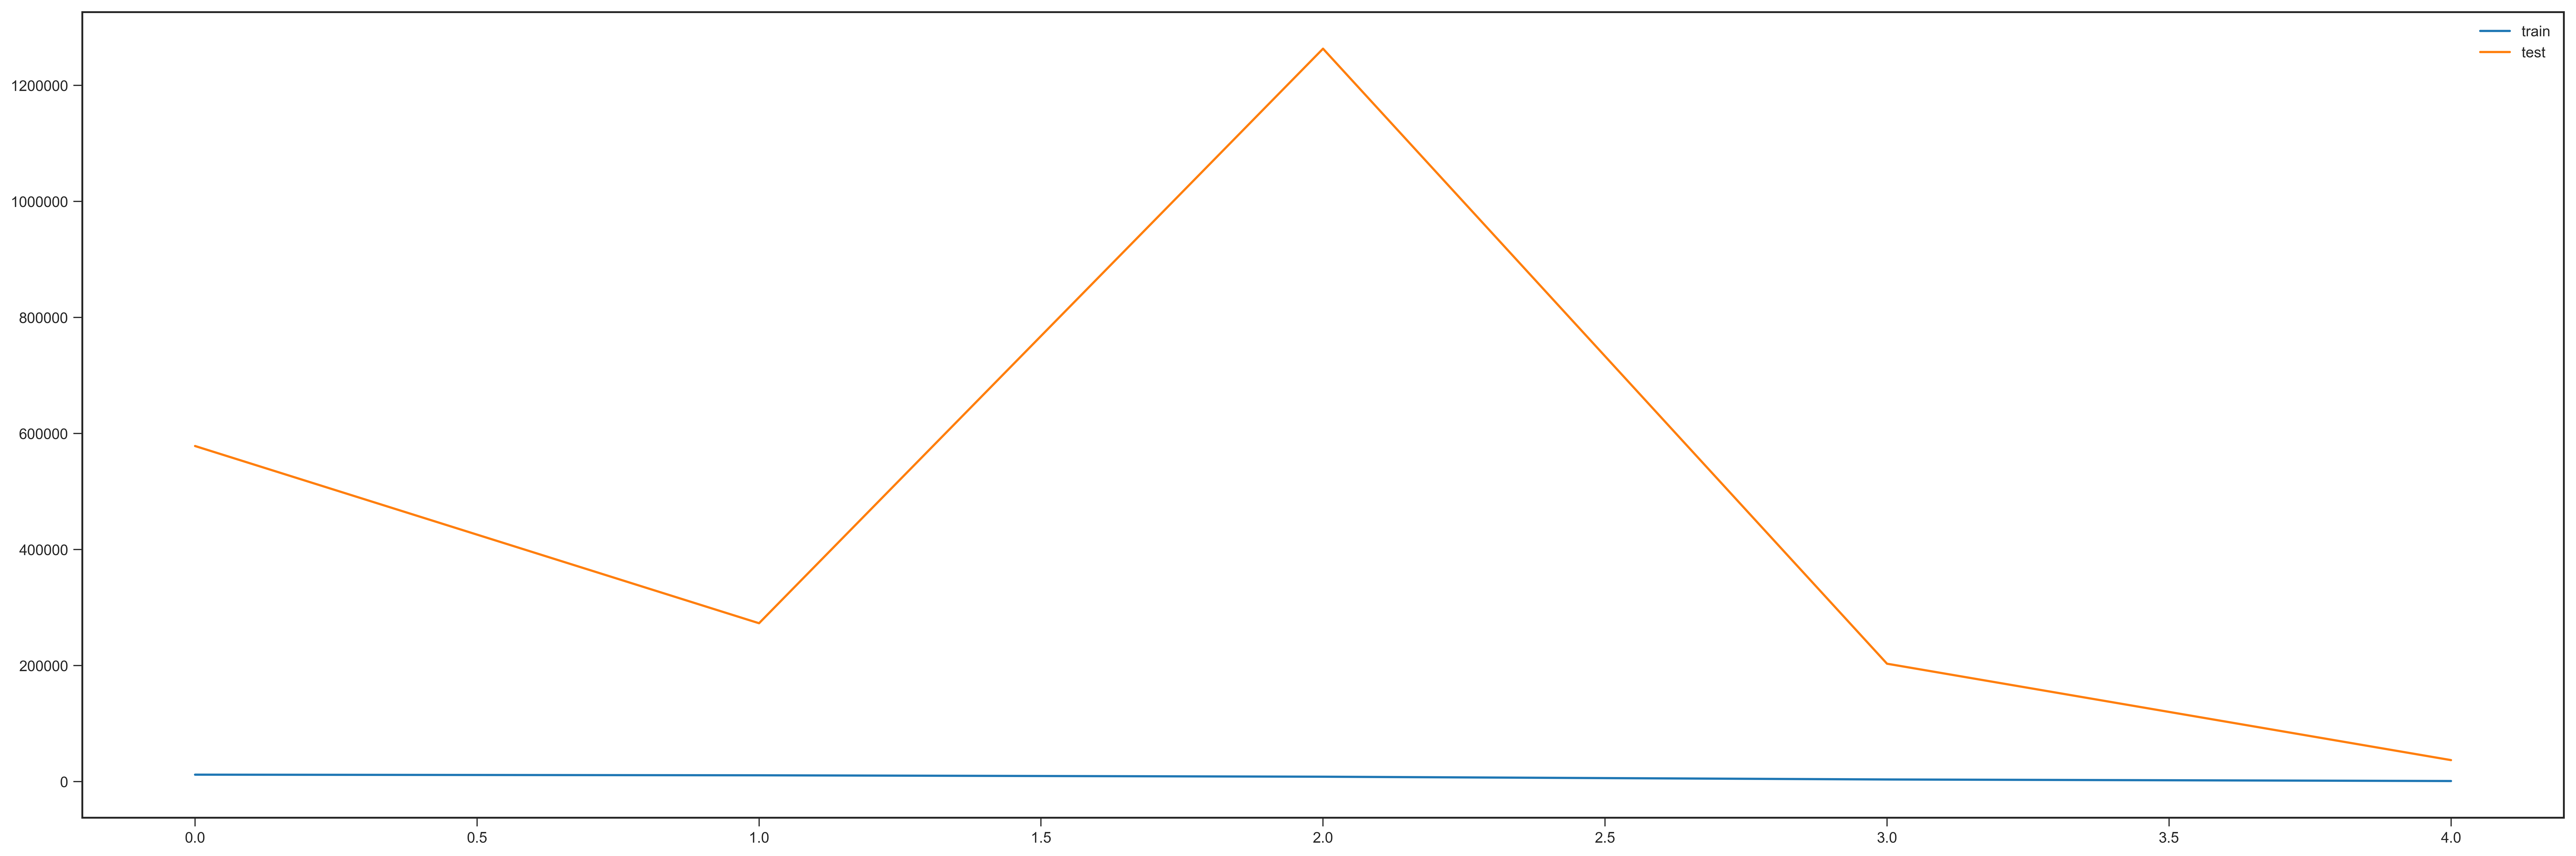

In [19]:
# plot history
history = brain.history
pyplot.figure(figsize=(30, 10), dpi=400)
axes = pyplot.gca()
# axes.set_ylim([0,0.5])
pyplot.plot(history.history['val_mean_absolute_percentage_error'], label='train')
pyplot.plot(history.history['mean_absolute_percentage_error'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
i = 5000
yhat = brain.predict(test_X[i].reshape(1, history_length, -1))
((test_y[i]-yhat)/test_y[i])*100

In [16]:
brain.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           25664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 48)           153648    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 48)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 32)           76832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 62, 32)            0         
__________